# 9BR_vocab_goterms

12/01/2020


- a. Dot plot of subset of common normal tissue vocabularies ? 
- b.    GO terms of common normal tissue vocabulary connected genes
- c.    Dot plot of a subset of regulatory TF vocabularies across all 17 normal cell types
- d.    Dot plot of common cancer vocabularies
- e.     Common cancer connected vocab genes and/or GO Terms


dot plots in R

In [16]:
library(tidyverse)
library(pheatmap)


library(clusterProfiler)
library(ReactomePA)
library(annotate)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)


save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [8]:
save_prefix ='../data/processed/fig7_vocab_go/'

In [4]:
tissue_colors = read.csv( '../data/processed/fig3_footprinting/tissue_colors.csv',stringsAsFactors=F)
tissue_colors

tissue,color
<chr>,<chr>
Airway,#4A195D
Astrocytes,#A8EAFF
Bladder,#C2A7D2
Colon,#F5AF1A
Esophageal,#FFDA89
GDSD0,#240201
GDSD3,#4E0A05
GDSD6,#A22633
GM12878,#8F99AC


In [35]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue = rna_df_tissue[tf_order,]
rna_df_tissue$SCC = rowMeans(rna_df_tissue[,c('A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi')])
rna_df_tissue$MC = rowMeans(rna_df_tissue[,c('COLO_SCR_DMSO','SKMEL5_SCR_DMSO','WM_SCR_DMSO')])
rna_df_tissue_log = log2(rna_df_tissue+1e-2)
rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))
rna_df_tissue_norm[rna_df_tissue_norm>2] = 2
rna_df_tissue_norm[rna_df_tissue_norm < -2] = -2
head(rna_df_tissue_norm)

,A431-CTRLi,A431-p63i,Airway,Astrocytes,Bladder,CAL27-CTRLi,CAL27-p63i,COLO_SCR_DMSO,COLO_SCR_PLX,COLO_shMITF_DMSO,⋯,SKMEL5_shMITF-DMSO,SKMEL5_shMITF_PLX,Thyroid,Uterine,WM_SCR_DMSO,WM_SCR_PLX,WM_shMITF_DMSO,WM_shMITF_PLX,SCC,MC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KLF5,1.4083269,1.400749150,1.1106106,0.29048284,1.1274674,0.984028731,1.2880717,0.2026066,-0.1392393,0.40401636,⋯,-0.40660624,-0.25994112,1.11691683,1.1992398,-0.50986500,-0.75702890,-0.37257256,-0.36116697,1.2714023,-0.2804128
RORA,-0.9214867,-0.477936108,-0.2456033,0.26736054,-0.2471668,-1.204448440,-0.9019597,0.1171462,0.3041207,0.07429404,⋯,0.16721924,0.33361253,-0.14571238,-0.9481358,-0.46444542,-0.07844064,-0.42946426,-0.29345857,-0.2545351,-0.1018334
THAP1,-0.2041549,0.007593732,0.2948269,0.05474419,0.1425446,-0.009802357,-0.1350073,0.3646446,0.3635211,0.44115673,⋯,0.23384897,0.09853226,0.11831385,0.1646215,0.09530478,0.01559235,0.06329188,0.05318517,-0.1835174,0.1045345
KLF15,-1.4563525,-1.138173166,-0.4562367,-1.84722796,-1.5699207,-1.349299414,-1.2939340,-0.6072020,-0.3128504,-0.30002789,⋯,0.04614495,-0.37214481,-0.07935223,-2.0000000,-0.92527654,-0.48035029,-0.54182756,-0.54515376,-1.6270737,-0.4572008
PRRX1,-1.8378073,-1.952075874,-1.9335401,1.33799597,-1.1439514,-1.844548167,-2.0000000,-0.6072020,-0.3469447,-0.42821401,⋯,-0.73079865,-0.71798184,-2.00000000,-1.2761671,1.61303547,1.47359681,1.63050869,1.49651812,-2.0000000,1.3173411
IRF8,-1.8378073,-1.805489301,-1.7863317,-1.29753263,-1.1439514,-1.844548167,-1.7616807,-1.9431470,-1.8276098,-1.98503403,⋯,-1.19518779,-1.54311396,-0.04834895,-1.1475612,-1.39553752,-2.00000000,-2.00000000,-2.00000000,-2.0000000,-1.5844114


In [82]:
colnames(rna_df_tissue_norm)

[1] "A431-CTRLi"         "A431-p63i"          "Airway"            
 [4] "Astrocytes"         "Bladder"            "CAL27-CTRLi"       
 [7] "CAL27-p63i"         "COLO_SCR_DMSO"      "COLO_SCR_PLX"      
[10] "COLO_shMITF_DMSO"   "COLO_shMITF_PLX"    "Colon"             
[13] "D0-CTRLi"           "D0-p63i"            "D3-CTRLi"          
[16] "D3-p63i"            "Esophageal"         "GDSD0"             
[19] "GDSD3"              "GDSD6"              "GM12878"           
[22] "HMEC"               "Melanocytes"        "Ovarian"           
[25] "Pancreas"           "Prostate"           "Renal"             
[28] "SCC13-CTRLi"        "SCC13-p63i"         "SKMEL5_SCR_DMSO"   
[31] "SKMEL5_SCR_PLX"     "SKMEL5_shMITF-DMSO" "SKMEL5_shMITF_PLX" 
[34] "Thyroid"            "Uterine"            "WM_SCR_DMSO"       
[37] "WM_SCR_PLX"         "WM_shMITF_DMSO"     "WM_shMITF_PLX"     
[40] "SCC"                "MC"

# a. dot plot normal tissues



In [10]:
normal_vocab_df = read.csv(paste0(save_prefix, 'normal_vocab_df.csv'))
normal_vocab_df = left_join(normal_vocab_df, tissue_colors, by='tissue')
head(normal_vocab_df)

Warning message:
“Column `tissue` joining factor and character vector, coercing into character vector”


,X,index,vocab_pair,tissue,vocab1,vocab2,color
,<int>,<int>,<fct>,<chr>,<fct>,<fct>,<chr>
1,0,0,BARX2::FOXF2,Colon,BARX2,FOXF2,#F5AF1A
2,1,1,BARX2::FOXM1,Colon,BARX2,FOXM1,#F5AF1A
3,2,2,BARX2::THAP1,Colon,BARX2,THAP1,#F5AF1A
4,3,3,BATF::KLF15,Colon,BATF,KLF15,#F5AF1A
5,4,4,E2F7::THAP1,Colon,E2F7,THAP1,#F5AF1A
6,5,5,FLI1::FOXM1,Colon,FLI1,FOXM1,#F5AF1A


In [39]:
normal_vocab_df_long1 = normal_vocab_df[,c("vocab1",'index','tissue','color')]
colnames(normal_vocab_df_long1) = c("tf_name",'number','tissue','color')
normal_vocab_df_long2 = normal_vocab_df[,c("vocab2",'index','tissue','color')]
colnames(normal_vocab_df_long2) = c("tf_name",'number','tissue','color')
normal_vocab_df_long = rbind(normal_vocab_df_long1, normal_vocab_df_long2)
normal_vocab_df_long$score = .5
str(normal_vocab_df_long)

'data.frame':	312 obs. of  5 variables:
 $ tf_name: Factor w/ 99 levels "ARID5B","ASCL2",..: 4 4 4 5 8 17 22 22 22 22 ...
 $ number : int  0 1 2 3 4 5 6 7 8 9 ...
 $ tissue : chr  "Colon" "Colon" "Colon" "Colon" ...
 $ color  : chr  "#F5AF1A" "#F5AF1A" "#F5AF1A" "#F5AF1A" ...
 $ score  : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...


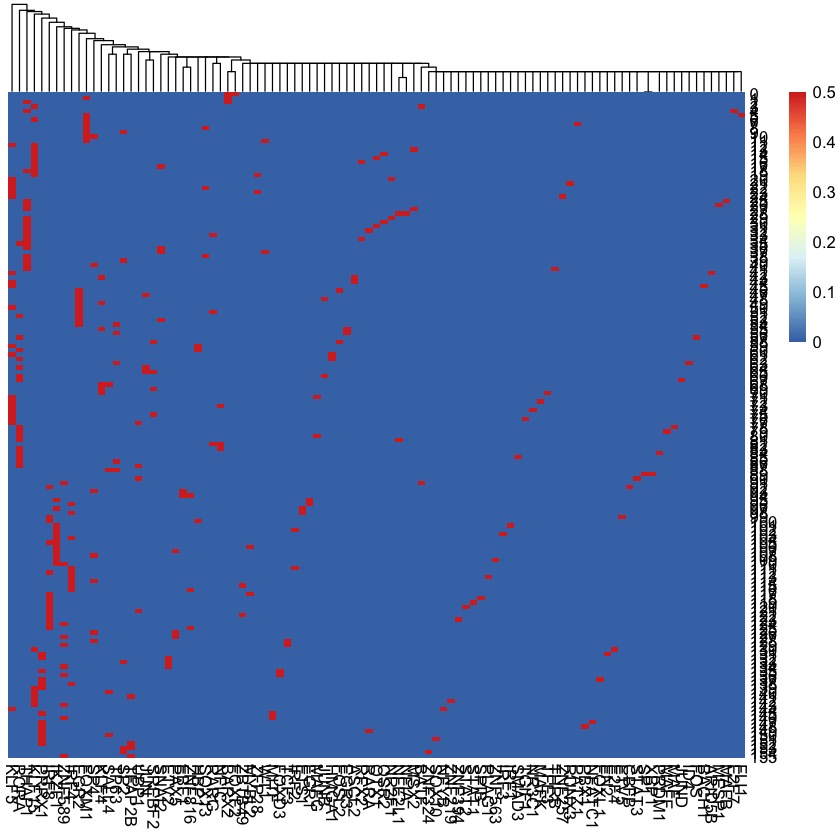

In [40]:
normal_vocab_df_spread = normal_vocab_df_long%>%
    dplyr::select(tf_name, score,number)%>%
    pivot_wider(names_from = tf_name, values_from = score)%>%
    column_to_rownames("number")
normal_vocab_df_spread[is.na(normal_vocab_df_spread)] = 0
p = pheatmap(normal_vocab_df_spread,
        cluster_row=F)
tf_order = colnames(normal_vocab_df_spread)[p$tree_col[['order']]]

In [41]:
tissue_colors_filt = filter(tissue_colors, tissue %in%unique(normal_vocab_df_long$tissue))
tissue_colors_filt

tissue,color
<chr>,<chr>
Colon,#F5AF1A
GDSD6,#A22633
GM12878,#8F99AC
Melanocytes,#189BDD


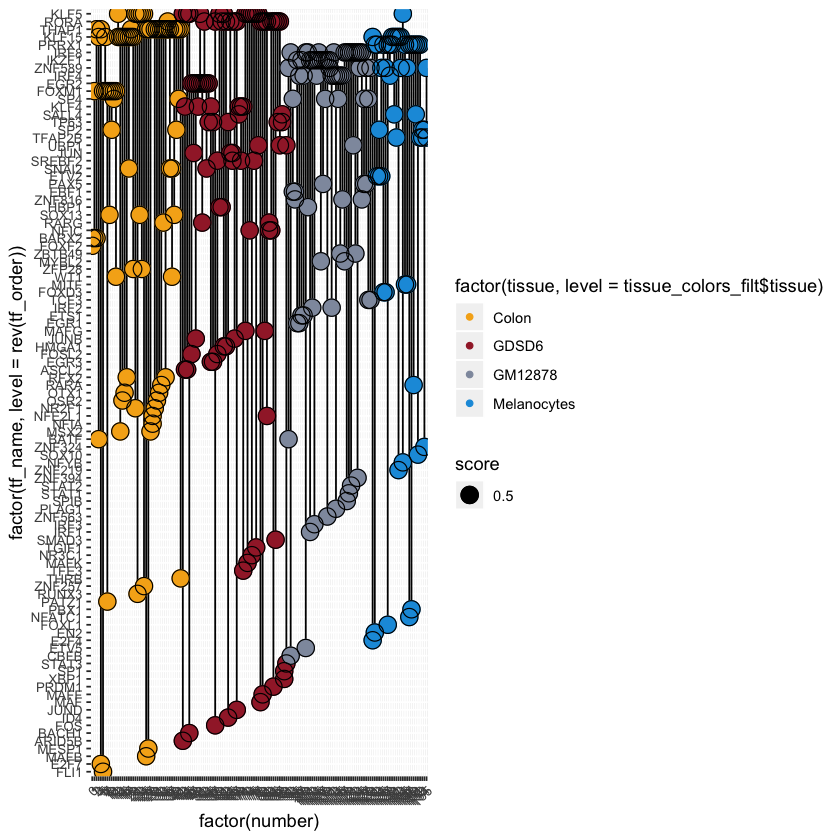

In [84]:
p = ggplot(normal_vocab_df_long, aes(x= factor(number),y=factor(tf_name,level=rev(tf_order)),
                                          color=factor(tissue, level=tissue_colors_filt$tissue)))+
    geom_line(aes(group = factor(number)),color='black')+geom_point(aes(size=score))+ 
    scale_color_manual(values=tissue_colors_filt$color)+
    geom_point(aes(size=score),colour="black",pch=21)+
    theme(axis.text.y = element_text(size=8),
          axis.text.x = element_text(size=8, angle = 45,hjust=1))
p 
ggsave(file = paste0(save_prefix, "normal_vocab_tissue_pairs.eps"),height=12, width=20)
#

In [85]:
rna_df_tissue['SP4',tissue_colors_filt$tissue]#c('GDSD0','GDSD3','GDSD6','SCC','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi')]

,Colon,GDSD6,GM12878,Melanocytes
,<dbl>,<dbl>,<dbl>,<dbl>
SP4,1.22,0.93,3.575,0.995


pdf 
  2

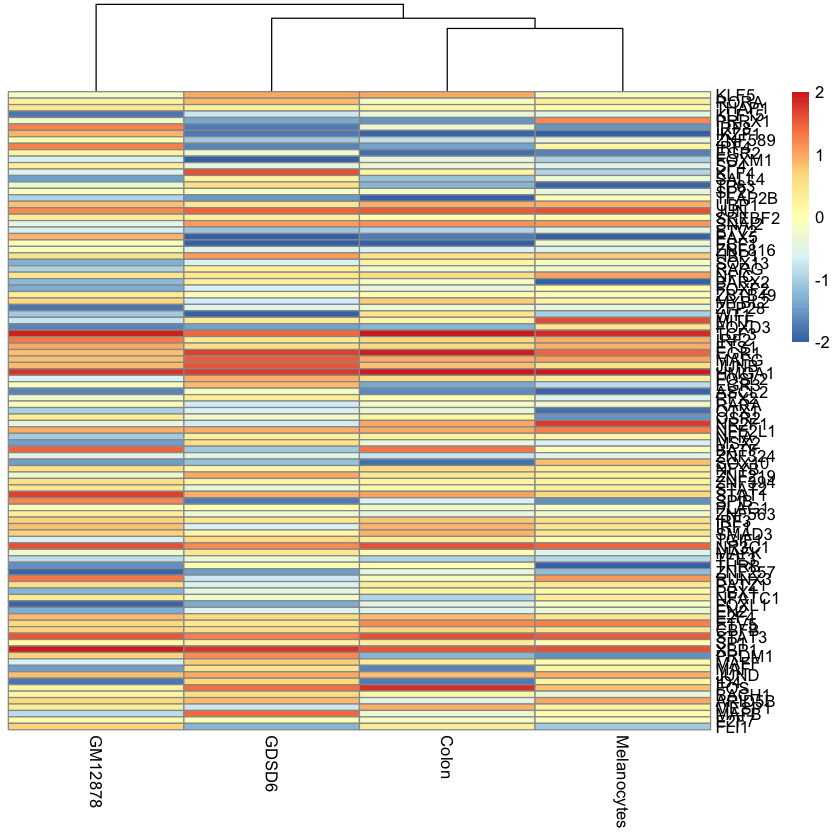

In [86]:
p_genexp = pheatmap(rna_df_tissue_norm[tf_order,tissue_colors_filt$tissue],cluster_rows=F)
save_pheatmap_pdf(p_genexp, paste0(save_prefix, 'normal_vocab_rna_heatmap.pdf'),  height=15,width=2) 

# B go terms normal
## B try 1 overall vocab per tissue

In [63]:
read_genes = function(filename){
    print(filename)
    target_genes = read.csv(filename,header=FALSE,stringsAsFactors=F)$V1
    print(length(target_genes))
    target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
    print(length(target_genes_entrez))
    return(target_genes_entrez)
}

In [64]:
Colon_genes= read_genes(paste0(save_prefix, 'Colon_geneset.txt'))
GDSD6_genes= read_genes(paste0(save_prefix, 'GDSD6_geneset.txt'))
GM12878_genes= read_genes(paste0(save_prefix, 'GM12878_geneset.txt'))
Melanocytes_genes= read_genes(paste0(save_prefix, 'Melanocytes_geneset.txt'))


[1] "../data/processed/fig7_vocab_go/Colon_geneset.txt"
[1] 781


'select()' returned 1:1 mapping between keys and columns



[1] 781
[1] "../data/processed/fig7_vocab_go/GDSD6_geneset.txt"
[1] 603


'select()' returned 1:1 mapping between keys and columns



[1] 603
[1] "../data/processed/fig7_vocab_go/GM12878_geneset.txt"
[1] 544


'select()' returned 1:1 mapping between keys and columns



[1] 544
[1] "../data/processed/fig7_vocab_go/Melanocytes_geneset.txt"
[1] 192


'select()' returned 1:1 mapping between keys and columns



[1] 192


In [65]:
list_normal = list(Colon=Colon_genes, KC = GDSD6_genes, GM12878=GM12878_genes, MC = Melanocytes_genes)

In [66]:
ck_go_bp <- compareCluster(geneCluster = list_normal, fun = "enrichGO", 
                                pAdjustMethod='BH', # 'BH',
                                pvalueCutoff  = 0.5,
                                qvalueCutoff  = 0.5,#0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,Colon,GO:0045930,negative regulation of mitotic cell cycle,35/738,338/18670,2.126646e-07,0.001048436,0.0009307992,ANAPC15/AURKAIP1/AURKB/BCL2L1/BUB1B/CDC20/CDK2/CDK4/CDK5RAP3/CDKN1B/CHMP4C/CNOT6/CTDSP1/CTDSP2/E4F1/GADD45GIP1/HECA/HUS1/KLF4/MAD2L2/MDM4/PML/PRMT1/PSMC3/PSMC6/PSMD8/PSME2/RAD9A/RINT1/RIPK1/RPL24/SFN/SLC9A3R1/XRCC3/ZFP36L1,35
2,Colon,GO:1901991,negative regulation of mitotic cell cycle phase transition,27/738,248/18670,1.988155e-06,0.004900803,0.0043509207,ANAPC15/AURKB/BUB1B/CDC20/CDK2/CDK4/CDK5RAP3/CDKN1B/CHMP4C/CNOT6/CTDSP1/CTDSP2/HUS1/KLF4/MAD2L2/MDM4/PML/PRMT1/PSMC3/PSMC6/PSMD8/PSME2/RINT1/RIPK1/SFN/XRCC3/ZFP36L1,27
3,Colon,GO:0006979,response to oxidative stress,39/738,451/18670,4.222116e-06,0.006938345,0.0061598456,ACOX2/ADA/ALDH3B1/ANKZF1/ATP2A2/CBX8/CDK2/CLN8/CYGB/ERCC1/FOSL1/GJB2/GPX1/GSS/HSPB1/IDH1/KLF4/LCN2/LDHA/MAP3K5/MAPK3/MCL1/MT3/NDUFS8/NFE2L1/NOL3/NR4A2/OXSR1/PML/PPP2CB/PRDX2/PRKCD/PTPRK/RELA/RIPK1/RPS3/RWDD1/TXN2/ZNF580,39
4,Colon,GO:0070482,response to oxygen levels,35/738,394/18670,7.293173e-06,0.006942055,0.0061631401,ACTN4/ACVRL1/ADA/ADAM15/ATP6V1A/BACH1/CAV1/CBL/CCDC115/CDK4/CDKN1B/CYGB/DDIT4/EEF2K/HIF1AN/ICAM1/LDHA/MDM4/MT3/NOL3/NPEPPS/NR4A2/PLAT/PLAU/PML/PSMC3/PSMC6/PSMD8/PSME2/SLC9A1/TGFBR2/TXN2/UBC/VEGFA/ZFP36L1,35
5,Colon,GO:1901988,negative regulation of cell cycle phase transition,27/738,267/18670,8.000862e-06,0.006942055,0.0061631401,ANAPC15/AURKB/BUB1B/CDC20/CDK2/CDK4/CDK5RAP3/CDKN1B/CHMP4C/CNOT6/CTDSP1/CTDSP2/HUS1/KLF4/MAD2L2/MDM4/PML/PRMT1/PSMC3/PSMC6/PSMD8/PSME2/RINT1/RIPK1/SFN/XRCC3/ZFP36L1,27
6,Colon,GO:0007093,mitotic cell cycle checkpoint,20/738,165/18670,8.491986e-06,0.006942055,0.0061631401,ANAPC15/AURKB/BCL2L1/BUB1B/CDC20/CDK2/CDK5RAP3/CDKN1B/CHMP4C/CNOT6/HUS1/MAD2L2/MDM4/PML/PRMT1/RAD9A/RINT1/RPL24/SFN/XRCC3,20


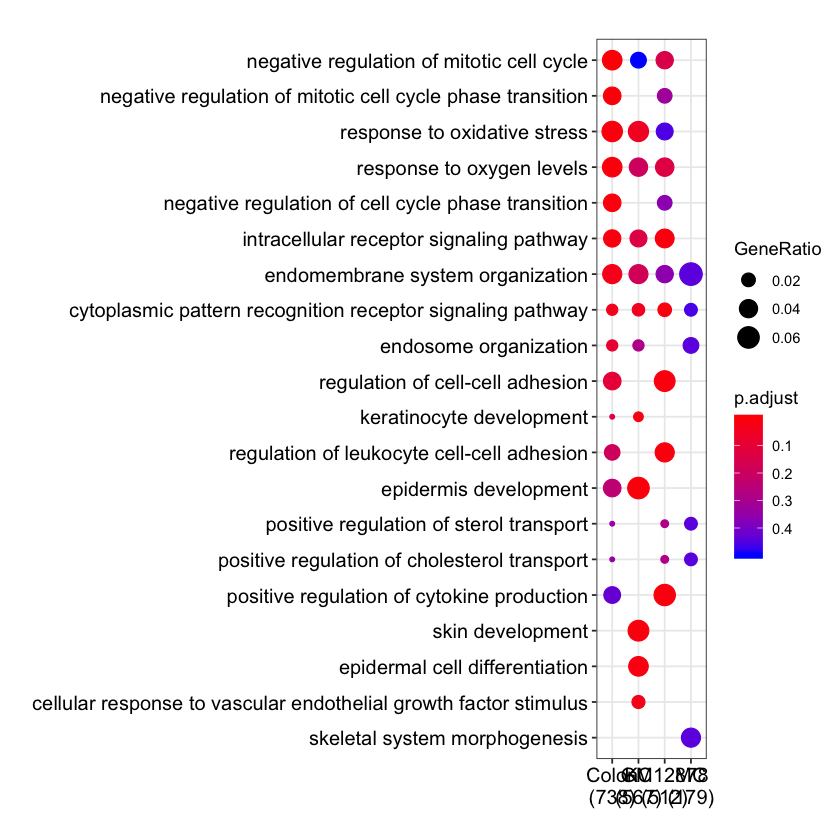

In [68]:
head(ck_go_bp)
write.csv(ck_go_bp, file=paste0(save_prefix, 'normal_vocab_go_bp.csv'))
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "normal_vocab_go_bp.pdf"),height=7, width=10)


# cancer dotplot

In [69]:
cancer_vocab_df = read.csv(paste0(save_prefix, 'cancer_vocab_df.csv'))
cancer_vocab_df = left_join(cancer_vocab_df, tissue_colors, by='tissue')
head(cancer_vocab_df)

Warning message:
“Column `tissue` joining factor and character vector, coercing into character vector”


,X,index,vocab_pair,tissue,vocab1,vocab2,color
,<int>,<int>,<fct>,<chr>,<fct>,<fct>,<chr>
1,0,0,ARNT::SP1,SCC,BARX2,FOXF2,NA
2,1,1,E2F1::SP1,SCC,BARX2,FOXM1,NA
3,2,2,E2F3::TP63,SCC,BARX2,THAP1,NA
4,3,3,E2F6::SP1,SCC,BATF,KLF15,NA
5,4,4,EGR1::SP1,SCC,E2F7,THAP1,NA
6,5,5,EGR1::SP3,SCC,FLI1,FOXM1,NA


In [70]:
cancer_vocab_df_long1 = cancer_vocab_df[,c("vocab1",'index','tissue','color')]
colnames(cancer_vocab_df_long1) = c("tf_name",'number','tissue','color')
cancer_vocab_df_long2 = cancer_vocab_df[,c("vocab2",'index','tissue','color')]
colnames(cancer_vocab_df_long2) = c("tf_name",'number','tissue','color')
cancer_vocab_df_long = rbind(cancer_vocab_df_long1, cancer_vocab_df_long2)
cancer_vocab_df_long$score = .5
str(cancer_vocab_df_long)

'data.frame':	166 obs. of  5 variables:
 $ tf_name: Factor w/ 57 levels "ARID5B","ASCL2",..: 4 4 4 5 6 9 12 12 12 12 ...
 $ number : int  0 1 2 3 4 5 6 7 8 9 ...
 $ tissue : chr  "SCC" "SCC" "SCC" "SCC" ...
 $ color  : chr  NA NA NA NA ...
 $ score  : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...


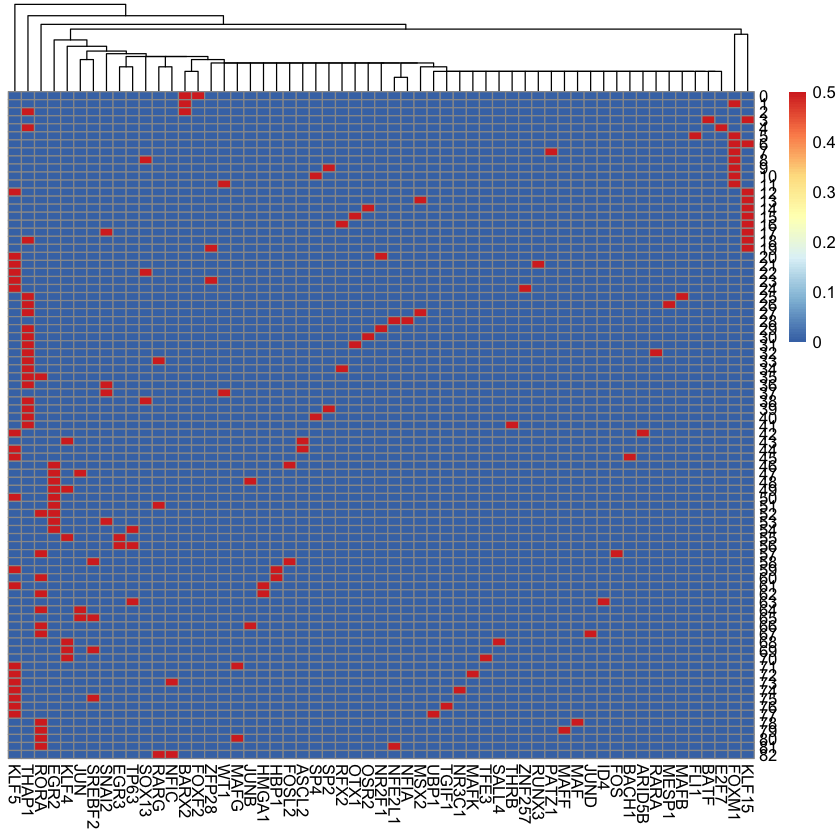

In [99]:
cancer_vocab_df_spread = cancer_vocab_df_long%>%
    dplyr::select(tf_name, score,number)%>%
    pivot_wider(names_from = tf_name, values_from = score)%>%
    column_to_rownames("number")
cancer_vocab_df_spread[is.na(cancer_vocab_df_spread)] = 0
p = pheatmap(cancer_vocab_df_spread,
        cluster_row=F)
tf_order = colnames(cancer_vocab_df_spread)[p$tree_col[['order']]]

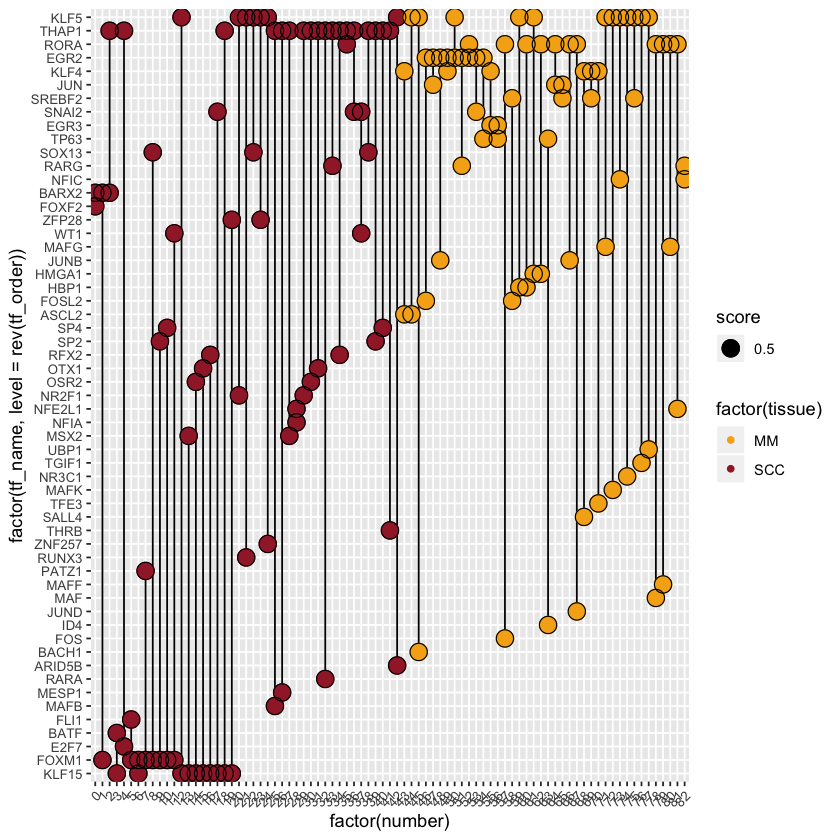

In [100]:
p = ggplot(cancer_vocab_df_long, aes(x= factor(number),y=factor(tf_name,level=rev(tf_order)),
                                          color=factor(tissue)))+#, level=tissue_colors_filt$tissue)))+
    geom_line(aes(group = factor(number)),color='black')+geom_point(aes(size=score))+ 
    scale_color_manual(values=tissue_colors_filt$color)+
    geom_point(aes(size=score),colour="black",pch=21)+
    theme(axis.text.y = element_text(size=8),
          axis.text.x = element_text(size=8, angle = 45,hjust=1))
p 
ggsave(file = paste0(save_prefix, "cancer_vocab_tissue_pairs.eps"),height=8, width=15)
#

pdf 
  2

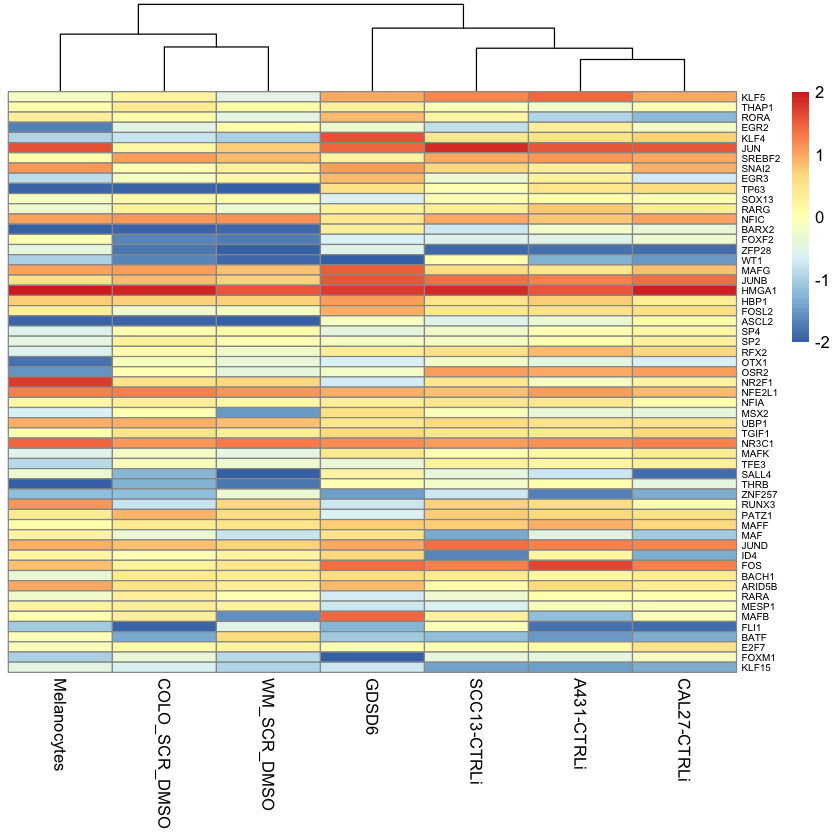

In [101]:
tissues_sel = c('A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi','GDSD6', 'COLO_SCR_DMSO','WM_SCR_DMSO','Melanocytes')

p_genexp = pheatmap(rna_df_tissue_norm[tf_order,tissues_sel],fontsize_row=6,cluster_rows=F)
save_pheatmap_pdf(p_genexp, paste0(save_prefix, 'cancer_vocab_rna_heatmap.pdf'),  height=8,width=2) 

In [105]:
rna_df_tissue['KLF15',tissues_sel]

,A431-CTRLi,CAL27-CTRLi,SCC13-CTRLi,GDSD6,COLO_SCR_DMSO,WM_SCR_DMSO,Melanocytes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KLF15,0.02,0.03,0.045,0.415,0.305,0.225,1.365


# cancer dot plot

In [78]:
SCC_genes= read_genes(paste0(save_prefix, 'SCC_geneset.txt'))
MM_genes= read_genes(paste0(save_prefix, 'MM_geneset.txt'))


[1] "../data/processed/fig7_vocab_go/SCC_geneset.txt"
[1] 1670


'select()' returned 1:1 mapping between keys and columns



[1] 1670
[1] "../data/processed/fig7_vocab_go/MM_geneset.txt"
[1] 837


'select()' returned 1:1 mapping between keys and columns



[1] 837


In [79]:
list_cancer = list(SCC=SCC_genes, KC = GDSD6_genes, MM=MM_genes, MC = Melanocytes_genes)

In [94]:
ck_go_bp <- compareCluster(geneCluster = list_cancer, fun = "enrichGO", 
                                pAdjustMethod='BH', # 'BH',
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,#0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,SCC,GO:0048193,Golgi vesicle transport,59/1566,368/18670,9.875589e-07,0.003905652,0.003548003,ACTR1A/AP3D1/AP4M1/ARFRP1/CAPZA2/CCDC93/CD55/CNIH2/COG2/COG4/COG8/COMMD1/COPG1/COPZ2/CORO7/CREB3L2/CSK/CUX1/DCTN1/DCTN5/DYNC1H1/DYNC1LI2/EXOC2/EXOC6B/GABARAPL2/GBF1/GGA2/GGA3/GOLGA5/KIF1C/KIF22/KIF2C/KIFAP3/MIA2/MYO18A/OPTN/PEF1/PPP6R1/PREB/PROC/RAB1B/RAB8B/RER1/RINT1/SAR1B/SCAMP3/SCFD1/SEC22C/SEC23B/SEC31A/SPTBN2/STEAP2/TEX261/TRAPPC5/TRAPPC8/VAMP2/VPS51/VTI1B/YIF1A,59
2,SCC,GO:0032984,protein-containing complex disassembly,54/1566,329/18670,1.352841e-06,0.003905652,0.003548003,ATG14/AURKAIP1/CAPZA2/CHCHD1/CHMP1A/CHMP2A/DDIT4/DENR/DSTN/DVL1/DVL3/EIF5A/F2RL1/FZD2/GABARAPL2/GADD45GIP1/GBA/KIF2C/LAMP2/MCOLN1/MICAL3/MRPL10/MRPL11/MRPL14/MRPL18/MRPL21/MRPL27/MRPL33/MRPL34/MRPL36/MRPL44/MRPL49/MRPL50/MRPL55/MRPS27/MRPS36/MRPS7/PHF23/PPP1CA/SCAF8/SH3BP1/SH3GL1/SMARCD1/SPTBN2/STMN1/STMN3/SYNJ1/TECPR1/TRIOBP/TRMT112/TWF1/VPS4B/WDR1/ZFAND1,54
3,SCC,GO:0033108,mitochondrial respiratory chain complex assembly,22/1566,96/18670,1.122307e-05,0.021600678,0.019622660,AARS2/BCS1L/COA4/COA5/COX14/COX19/ECSIT/FOXRED1/NDUFA11/NDUFA6/NDUFB11/NDUFB7/NDUFB8/NDUFB9/NDUFS6/NDUFS7/NDUFS8/PET100/SAMM50/SLC25A33/SURF1/TAZ,22
4,SCC,GO:0006605,protein targeting,62/1566,432/18670,2.062865e-05,0.023781219,0.021603525,ABLIM3/ACOX3/AP1M2/AP3D1/AP4M1/ARL6IP1/CAT/CDK5/DECR2/ECI2/EHHADH/FBXO7/FBXW7/GOLGA7B/GRPEL2/HPS4/HSPA4/IDH1/KIF13B/LAMP2/LONP2/MICALL1/MICALL2/MIEF2/NPEPPS/PEX16/PMPCA/RAB8B/RHOD/RNF31/RPL10/RPL18/RPL22/RPL24/RPL27A/RPL3/RPL32/RPL37/RPL38/RPL6/RPL7A/RPL9/RPLP2/RPS10/RPS2/RPS21/RPS26/RPS3/RPS9/SAMM50/SMURF1/SPCS3/SREBF1/SREBF2/SRP9/TRAK2/TRAM2/UBC/VPS11/VPS37C/VTI1B/ZDHHC7,62
5,SCC,GO:0006979,response to oxidative stress,64/1566,451/18670,2.181810e-05,0.023781219,0.021603525,ADA/AKR1C3/ALDH3B1/ANKZF1/ATP2A2/BAG5/BTG1/CAT/CDK2/CLN8/CRYAB/CYP1B1/DUOX1/ERCC1/FBXO7/FBXW7/FOSL1/GJB2/GPX1/GSS/HMOX2/HNRNPM/HSPB1/IDH1/KLF4/LCN2/LDHA/LIAS/MAP3K5/MAPK3/MB/MCL1/MMP14/NCOA7/NDUFA6/NDUFS8/NFE2L1/NOL3/NR4A2/NUDT1/OXSR1/PLEKHA1/PML/PPARGC1B/PPP2CB/PRDX1/PRDX2/PRDX5/PRKCD/PSAP/PTK2B/PTPRK/RELA/RIPK1/RPS3/RWDD1/SDC1/SESN2/SLC23A2/SPHK1/TRPM2/TXN2/XRCC1/ZNF580,64
6,SCC,GO:0010803,regulation of tumor necrosis factor-mediated signaling pathway,16/1566,61/18670,2.977119e-05,0.023781219,0.021603525,ADAM17/BIRC3/CPNE1/F2RL1/HIPK1/MADD/NOL3/PELI3/RFFL/RIPK1/RNF31/SHARPIN/SPATA2/SPHK1/TRADD/TRAIP,16


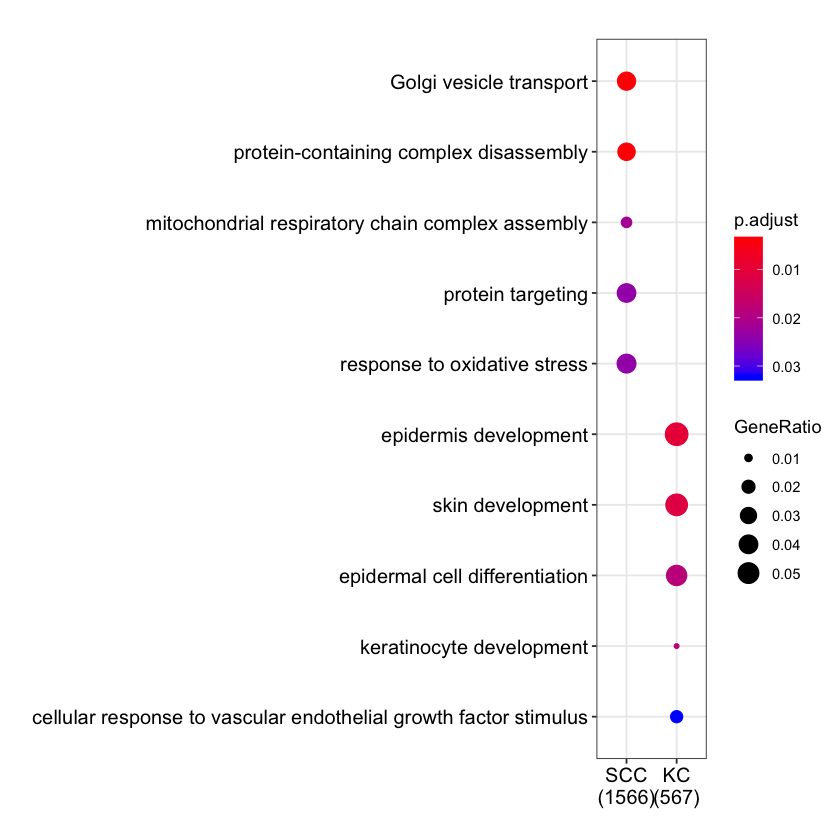

In [95]:
head(ck_go_bp)
write.csv(ck_go_bp, file=paste0(save_prefix, 'cancer_vocab_go_bp.csv'))
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "cancer_vocab_go_bp.pdf"),height=7, width=10)
